# Demo main

In [1]:
from preprocess.tissue_mask import GaussianTissueMask
from preprocess.utils import describe_img, read_image, get_tissue_mask, get_image_patches, resize_patch, normalize_patch, convert_patch_to_tensor

from osgen.loss import structure_preservation_loss, color_alignment_loss, content_loss, style_loss, total_loss
from osgen.pipeline import StyleTransferPipeline
from osgen.vit import extract_style_embedding

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")
from PIL import Image

/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hoangthuyduongvu/miniconda3/envs/BiOSGen/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define hyperparameters

In [2]:
Image.MAX_IMAGE_PIXELS = 100000000000

IMAGE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/HE/A3_TMA_15_02_IVB_HE.png"
STYLE_PATH = "/Users/hoangthuyduongvu/Desktop/BiOSGen/data/NKX3/A6_TMA_15_02_IIB_NKX.png"

# tissue mask params
tissue_mask_params = {
    'kernel_size': 20,
    'sigma': 20,
    'downsample': 8,
    'background_gray_threshold': 220
}

# patch extraction params
patch_extraction_params = {
    'patch_size': 128,
    'patch_tissue_threshold': 0.7,
    'is_visualize': True
}

## Process patches

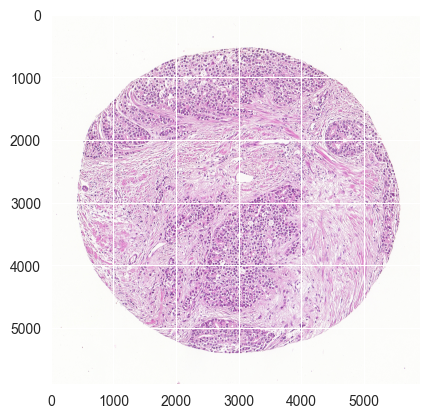

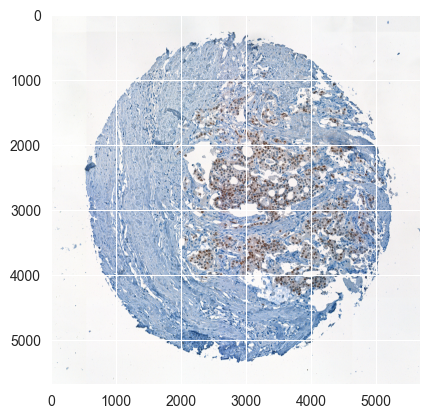

In [3]:
image_src = read_image(IMAGE_PATH)
plt.imshow(image_src)
plt.show()

image_dst = read_image(STYLE_PATH)
plt.imshow(image_dst)
plt.show()

Original size: 5896x5896
Downsampling factor: 8
New size: 737x737


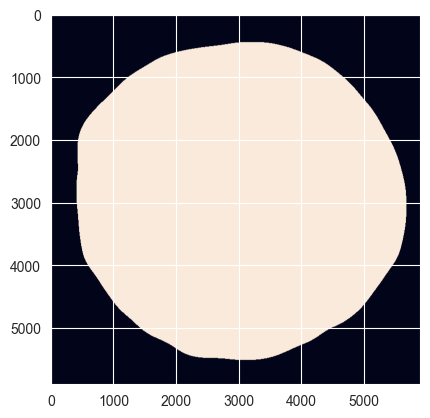

Original size: 5684x5684
Downsampling factor: 8
New size: 710x710


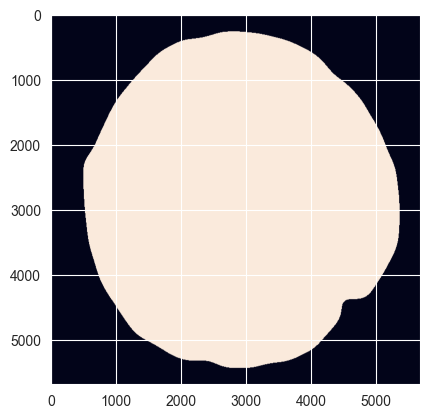

In [4]:
tissue_mask_src = get_tissue_mask(image=image_src, **tissue_mask_params)
plt.imshow(tissue_mask_src)
plt.show()

tissue_mask_dst = get_tissue_mask(image=image_dst, **tissue_mask_params)
plt.imshow(tissue_mask_dst)
plt.show()

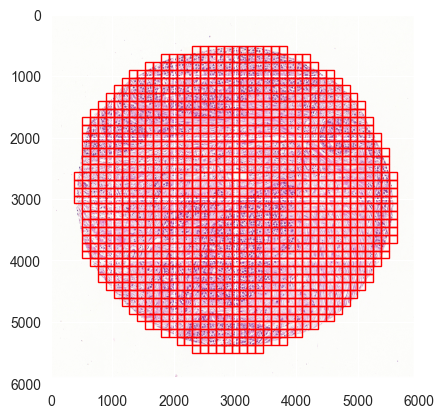

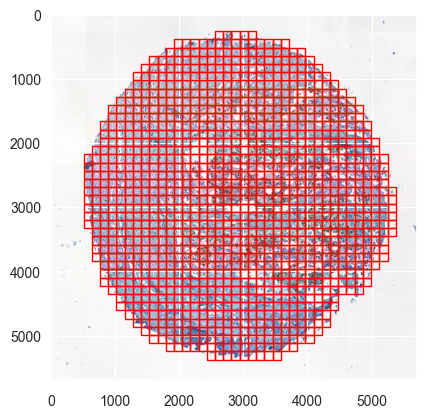

In [5]:
# extract src patches
patches_src = get_image_patches(
    image=image_src,
    tissue_mask=tissue_mask_src,
    **patch_extraction_params
)

# extract dst patches
patches_dst = get_image_patches(
    image=image_dst,
    tissue_mask=tissue_mask_dst,
    **patch_extraction_params
)

## Load patches

In [6]:
batch_size = 100
batch_src = patches_src[:batch_size]
batch_dst = patches_dst[:batch_size]

batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)
batch_dst = torch.Tensor(batch_dst).permute(0, 3, 1, 2)

# Check shape
print(batch_src.shape)
print(batch_dst.shape)

torch.Size([100, 3, 128, 128])
torch.Size([100, 3, 128, 128])


/var/folders/9t/hj30jvr52kscxxdg1z2kq1600000gn/T/ipykernel_28111/1068247497.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch_src = torch.Tensor(batch_src).permute(0, 3, 1, 2)


## Train

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import loralib as lora
from tqdm import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt

def train_style_transfer(
    source_images,  # Shape: [N, 3, 128, 128]
    target_images,  # Shape: [N, 3, 128, 128]
    num_epochs=10,
    batch_size=8,
    learning_rate=1e-4,
    gradient_clip_val=1.0,
    device="cuda" if torch.cuda.is_available() else "cpu",
    save_path="style_transfer_model.pt",
    log_interval=10,
    validation_images=None
):
    """
    Train the StyleTransferPipeline using LoRA fine-tuning
    
    Args:
        source_images: Tensor of source images [N, 3, 128, 128]
        target_images: Tensor of target style images [N, 3, 128, 128]
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        gradient_clip_val: Value for gradient clipping
        device: Device to train on
        save_path: Path to save the model
        log_interval: Interval for logging
        validation_images: Optional tensor of validation images
    """
    # Initialize model
    model = StyleTransferPipeline(device=device)
    model = model.to(device)
    
    # Apply LoRA and set only LoRA parameters as trainable
    lora.mark_only_lora_as_trainable(model)
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    # Initialize optimizer with weight decay for regularization
    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate,
        weight_decay=1e-5
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=2,
        verbose=True
    )
    
    # Track losses
    losses = []
    val_losses = []
    
    # Number of samples and batches
    num_samples = source_images.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        # Create epoch indices and shuffle for this epoch
        indices = torch.randperm(num_samples)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()
        
        # Process batches
        for batch_idx in tqdm(range(num_batches)):
            # Get batch indices
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]
            
            # Get batch data
            batch_src = source_images[batch_indices].to(device)
            batch_dst = target_images[batch_indices].to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            try:
                # Extract style embedding from target images
                style_embedding = extract_style_embedding(batch_dst[0], device=device)
                # Repeat for batch size
                style_embedding = style_embedding.repeat(batch_src.shape[0], 1)
                
                # Create random timesteps
                timesteps = torch.randint(0, 1000, (batch_src.shape[0],), device=device).long()
                
                # Forward pass
                output = model(batch_src, style_embedding, timesteps)
                
                # Compute loss with safe handling
                loss_value = total_loss(
                    batch_dst,  # Target as the reference for structural preservation
                    output,
                    lambda_structure=0.5,
                    lambda_color=1.0,
                    lambda_content=1.0,
                    lambda_style=0.8,
                    image_size=128
                )
                
                # Check for NaN loss
                if torch.isnan(loss_value):
                    print(f"NaN loss detected in batch {batch_idx}. Skipping batch.")
                    # Try to identify the source of NaN
                    print(f"Input stats - Min: {batch_src.min().item()}, Max: {batch_src.max().item()}")
                    print(f"Output stats - Min: {output.min().item()}, Max: {output.max().item()}")
                    continue
                
                # Backward pass with gradient scaling for stability
                loss_value.backward()
                
                # Clip gradients to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(
                    [p for p in model.parameters() if p.requires_grad],
                    gradient_clip_val
                )
                
                # Update parameters
                optimizer.step()
                
                # Update statistics
                epoch_loss += loss_value.item()
                
                # Log progress
                if (batch_idx + 1) % log_interval == 0:
                    print(f"  Batch {batch_idx+1}/{num_batches}, Loss: {loss_value.item():.6f}")
                    
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                # Continue with next batch
                continue
        
        # Compute average epoch loss
        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)
        
        # Validation if provided
        if validation_images is not None:
            val_loss = validate_model(model, validation_images, target_images, device)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1} - Training Loss: {avg_epoch_loss:.6f}, Validation Loss: {val_loss:.6f}")
            
            # Update learning rate based on validation loss
            scheduler.step(val_loss)
        else:
            print(f"Epoch {epoch+1} - Training Loss: {avg_epoch_loss:.6f}")
            
            # Update learning rate based on training loss
            scheduler.step(avg_epoch_loss)
        
        # Print epoch stats
        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")
        
        # Save model checkpoint
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }
            torch.save(checkpoint, f"{save_path.split('.')[0]}_epoch{epoch+1}.pt")
            print(f"Checkpoint saved at epoch {epoch+1}")
    
    # Save final model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    if validation_images is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.savefig('training_loss.png')
    plt.show()
    
    return model, losses


def validate_model(model, validation_images, style_images, device):
    """Validate the model on validation images"""
    model.eval()
    num_samples = validation_images.shape[0]
    batch_size = 4  # Smaller batch size for validation
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_samples)
            
            # Get batch data
            batch_src = validation_images[start_idx:end_idx].to(device)
            batch_style = style_images[0:1].to(device)  # Use first style image for all
            
            # Extract style embedding
            style_embedding = extract_style_embedding(batch_style[0], device=device)
            style_embedding = style_embedding.repeat(batch_src.shape[0], 1)
            
            # Fixed timesteps for validation
            timesteps = torch.ones((batch_src.shape[0],), device=device).long() * 500
            
            # Forward pass
            output = model(batch_src, style_embedding, timesteps)
            
            # Compute loss
            batch_loss = total_loss(
                batch_src,
                output,
                lambda_structure=0.5,
                lambda_color=1.0,
                lambda_content=1.0,
                lambda_style=0.8,
                image_size=128
            )
            
            total_loss += batch_loss.item()
    
    return total_loss / num_batches


def visualize_results(model, source_images, style_images, num_samples=4, device="cuda"):
    """Visualize style transfer results"""
    model.eval()
    
    # Select random samples
    indices = np.random.choice(source_images.shape[0], num_samples, replace=False)
    sample_sources = source_images[indices].to(device)
    
    # Use the first style image
    style_image = style_images[0:1].to(device)
    style_embedding = extract_style_embedding(style_image[0], device=device)
    style_embedding = style_embedding.repeat(sample_sources.shape[0], 1)
    
    # Generate outputs
    timesteps = torch.ones((sample_sources.shape[0],), device=device).long() * 500
    with torch.no_grad():
        outputs = model(sample_sources, style_embedding, timesteps)
    
    # Plot results
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Original
        orig = sample_sources[i].cpu().permute(1, 2, 0).numpy()
        orig = (orig * 255).astype(np.uint8)
        axes[i, 0].imshow(orig)
        axes[i, 0].set_title("Source")
        axes[i, 0].axis("off")
        
        # Style reference
        style = style_image[0].cpu().permute(1, 2, 0).numpy()
        style = (style * 255).astype(np.uint8)
        axes[i, 1].imshow(style)
        axes[i, 1].set_title("Style Reference")
        axes[i, 1].axis("off")
        
        # Result
        result = outputs[i].cpu().permute(1, 2, 0).numpy()
        result = (result * 255).astype(np.uint8)
        axes[i, 2].imshow(result)
        axes[i, 2].set_title("Result")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.savefig("style_transfer_results.png")
    plt.show()

In [26]:
model, losses = train_style_transfer(
    source_images=batch_src,
    target_images=batch_dst,
    num_epochs=10,
    batch_size=batch_size,
    learning_rate=0.0001,
    device='cpu',
    save_path="style_transfer_lora.pt",
)

# Visualize results
visualize_results(model, batch_src, batch_dst, num_samples=4, device='cpu')


Number of trainable parameters: 0


ValueError: optimizer got an empty parameter list

In [37]:
model = StyleTransferPipeline(device='cpu')

In [29]:
# Apply LoRA and set only LoRA parameters as trainable
lora.mark_only_lora_as_trainable(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 0


In [30]:
lora.mark_only_lora_as_trainable(model)

In [38]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 5300265


In [39]:
# Iterate through all parameters
for name, param in model.named_parameters():
    print(name)

encoder.conv_0.0.conv.weight
encoder.conv_0.0.conv.bias
encoder.bn_0.weight
encoder.bn_0.bias
encoder.conv_1.0.conv.weight
encoder.conv_1.0.conv.bias
encoder.bn_1.weight
encoder.bn_1.bias
encoder.conv_2.0.conv.weight
encoder.conv_2.0.conv.bias
encoder.bn_2.weight
encoder.bn_2.bias
encoder.conv_3.0.conv.weight
encoder.conv_3.0.conv.bias
encoder.bn_3.weight
encoder.bn_3.bias
encoder.conv_mu.conv.weight
encoder.conv_mu.conv.bias
encoder.conv_logvar.conv.weight
encoder.conv_logvar.conv.bias
unet.time_embed.0.weight
unet.time_embed.0.bias
unet.time_embed.2.weight
unet.time_embed.2.bias
unet.input_blocks.0.0.conv.weight
unet.input_blocks.0.0.conv.bias
unet.input_blocks.1.0.in_layers.0.weight
unet.input_blocks.1.0.in_layers.0.bias
unet.input_blocks.1.0.in_layers.2.conv.weight
unet.input_blocks.1.0.in_layers.2.conv.bias
unet.input_blocks.1.0.emb_layers.1.weight
unet.input_blocks.1.0.emb_layers.1.bias
unet.input_blocks.1.0.out_layers.0.weight
unet.input_blocks.1.0.out_layers.0.bias
unet.input_b

In [44]:
conv = nn.Sequential(
    lora.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    lora.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    lora.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    lora.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    lora.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    lora.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
)

In [46]:
# ===== Before =====
# layer = nn.Linear(in_features, out_features)

# ===== After ======
import loralib as lora
# Add a pair of low-rank adaptation matrices with rank r=16
layer = lora.Linear(67, 90, r=16)

In [ ]:
lora.mark_only_lora_as_trainable(layer, bias='lora_only')

In [50]:
trainable_params = sum(p.numel() for p in layer.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 2602


In [49]:
# Iterate through all parameters
for name, param in layer.named_parameters():
    print(name)

weight
bias
lora_A
lora_B


In [42]:
# Iterate through all parameters
for name, param in conv.named_parameters():
    print(name)

0.conv.weight
0.conv.bias
2.conv.weight
2.conv.bias
4.conv.weight
4.conv.bias
6.conv.weight
6.conv.bias
8.conv.weight
8.conv.bias
10.conv.weight
10.conv.bias
